In [29]:
import pandas as pd
import numpy as np
from pyxlsb import open_workbook as open_xlsb


In [30]:
def create_df(filepath):

    df = []

    with open_xlsb(filepath) as wb:
        with wb.get_sheet(2) as sheet:
            for row in sheet.rows():
                df.append([item.v for item in row])

    df = pd.DataFrame(df[1:], columns=df[0])

    return df

In [31]:
def filter_numeric_columns(df):
    numeric_cols=df.select_dtypes(include=['int','float']).columns.tolist()
    return numeric_cols
    

In [32]:
def filter_date_columns(numeric_cols,df):
    date_cols=[]
    for col in numeric_cols:
      if 'date' in col.lower():
          date_cols.append(col)
    return date_cols
        


In [33]:
def getNumericOutliers(df,filtered_list_numeric):
    numeric_outliers = {}
    percentiles=[]
    for col in filtered_list_numeric:

        column_values = df[col].values
        q1 = np.percentile(column_values, 25)
        q3 = np.percentile(column_values, 75)

        iqr = q3 - q1

        # Define outlier boundaries
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        # Identify outliers
        outlier_indices = np.where((column_values < lower_bound) | (column_values > upper_bound))[0]
        if len(outlier_indices)>0:
            numeric_outliers[col] = outlier_indices
            percentiles.append([lower_bound,upper_bound])


    return numeric_outliers,percentiles


In [34]:
def get_values_for_indices(df, outliers_dict):
    values_dict = {}
    for col, indices in outliers_dict.items():
        values_dict[col] = [df.loc[idx, col] for idx in indices]
    return values_dict


In [35]:
def get_dates_for_indices(df, outliers_dict):
    dates = []
    for indices in outliers_dict.values():
        dates.extend(df.loc[indices, 'PREAUTH_RECEIVED_DATE'].tolist())
    return dates

In [36]:
df=create_df('/home/intern/nalin/cost_containment/approval_data.xlsb')
num_cols=filter_numeric_columns(df)
date_columns=filter_date_columns(num_cols,df)
filtered_list_numeric = [col for col in num_cols if col not in date_columns]

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120170 entries, 0 to 120169
Data columns (total 68 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   PREAUTH_NUMBER                 120169 non-null  object        
 1   ADMISSION_DATE                 120169 non-null  float64       
 2   DISCHARGE_DATE                 120169 non-null  float64       
 3   CLAIM_NUMBER                   8583 non-null    object        
 4   MEMBER_INCEPTION_DATE          120169 non-null  float64       
 5   POLICY_NUMBER                  120169 non-null  object        
 6   POLICY_START_DATE              120169 non-null  float64       
 7   POLICY_END_DATE                120169 non-null  float64       
 8   CORPORATE_NAME                 120169 non-null  object        
 9   SOURCE_TYPE                    120169 non-null  object        
 10  PREAUTH_RECEIVED_DATE          120169 non-null  datetime64[ns]
 11  

In [37]:
numeric_outliers,percentile=getNumericOutliers(df,filtered_list_numeric)

In [40]:
numeric_outliers

{'NET_AMOUNT': array([     0,      1,      2, ..., 120155, 120156, 120169])}

In [38]:
values_dict = get_values_for_indices(df, numeric_outliers)
print(values_dict)

{'NET_AMOUNT': [5281.3, 1400.0, 20571.35, 8500.0, 1500.0, 1200.0, 2000.0, 1500.0, 11000.0, 1500.0, 2340.0, 2340.0, 1000.0, 5000.0, 1600.0, 5000.0, 2000.0, 990.0, 19500.0, 22330.0, 5500.0, 5500.0, 6000.0, 1000.0, 1500.0, 1000.0, 1000.0, 1640.0, 3000.0, 1800.0, 1100.0, 5250.0, 7880.0, 2000.0, 1200.0, 1800.0, 1800.0, 1800.0, 1800.0, 3100.0, 1550.0, 1550.0, 7500.0, 1550.0, 1386.0, 2010.0, 2651.0, 1200.0, 1500.0, 1800.0, 1112.0, 1980.0, 2500.0, 1200.0, 16677.5, 16500.0, 1350.0, 12600.0, 12600.0, 13130.0, 3400.0, 3450.0, 1400.0, 1400.0, 1550.0, 1550.0, 2000.0, 1280.0, 3200.0, 1057.2, 1305.0, 1305.0, 1926.0, 3200.0, 1938.51, 1200.0, 1040.0, 1500.0, 1800.0, 1800.0, 1395.0, 2340.0, 1980.0, 1485.0, 1400.0, 1400.0, 13860.0, 3432.0, 1200.0, 1592.0, 1540.8, 1926.0, 1080.0, 9900.0, 3432.0, 1200.0, 2400.0, 1582.0, 1386.0, 1760.0, 2153.9, 1286.0, 1286.0, 3000.0, 1550.0, 3524.0, 984.8, 1400.0, 1070.0, 3600.0, 6000.0, 1200.0, 1200.0, 3250.0, 1440.0, 1200.0, 1500.0, 1500.0, 5000.0, 2000.0, 1450.0, 1807.0

In [41]:
outlier_df=pd.DataFrame(values_dict)

In [63]:
df['PREAUTH_COMPLETED_DATE'] = pd.to_datetime(df['PREAUTH_COMPLETED_DATE'])

In [64]:
sliced_df=df.iloc[numeric_outliers['NET_AMOUNT']]
len(sliced_df)

12852

In [66]:
outlier_df['PREAUTH_COMPLETED_DATE']=sliced_df['PREAUTH_COMPLETED_DATE']

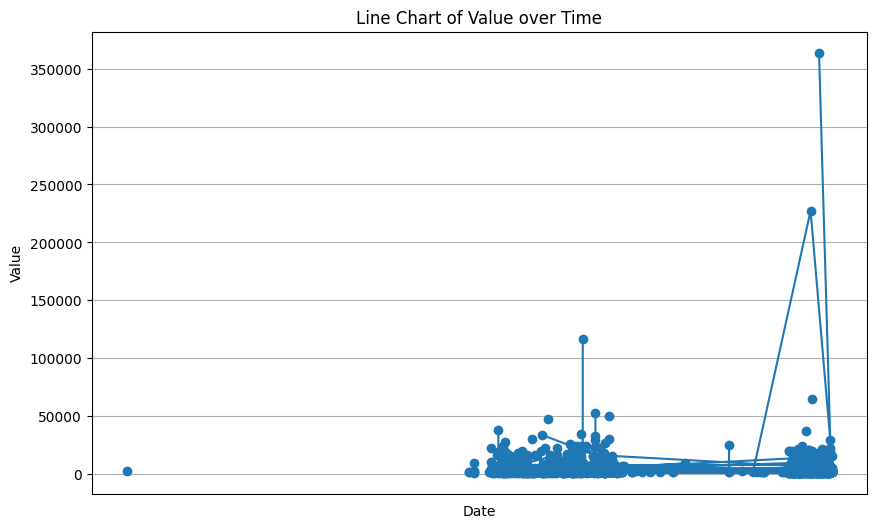

In [69]:
plt.figure(figsize=(10, 6))
plt.plot(outlier_df['PREAUTH_RECEIVED_DATE'], outlier_df['NET_AMOUNT'], marker='o', linestyle='-')
plt.title('Line Chart of Value over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.show()

In [53]:
outlier_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12852 entries, 0 to 12851
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   NET_AMOUNT             12852 non-null  float64       
 1   PREAUTH_RECEIVED_DATE  1594 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 200.9 KB
